# Machine Learning Group Project

This notebook contains the code for training our Machine Learning module which classifies the image into 101 categories of food. The dataset that we used for training and testing can be found here. https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#food101.

## Import modules

This section contains code to import all the code that is required for our ML pipeline.

### Installing Modules

Here we are installing all the necessary modules

In [ ]:
!pip install lightning
!pip install torchsummaryX
!pip install torcheval
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00


### Import Statements

In [ ]:
# Import statements
from torch.utils.data import DataLoader, Subset
import torch
from lightning.pytorch import LightningModule, Trainer
import torch.optim as optim
import torch.nn as nn
from torchsummaryX import summary
from torchvision import transforms, datasets
from lightning.pytorch.loggers import CSVLogger
from torchmetrics.classification import Accuracy
from torcheval.metrics import MulticlassAccuracy

## Import Dataset

This section contains downloading the dataset, changing it into dataloader compatible format and getting a training and testing data with 70-30 split.

### Import dataset from PyTorch

In [ ]:
# import dataset from python

# transformation to apply on the dataset
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# get training & testing data
train_iter = datasets.Food101(root='./dataset/food101/', split='train', download=True, transform=transform)
test_iter = datasets.Food101(root='./dataset/food101/', split='test', download=True, transform=transform)
train_iter, test_iter

100%|██████████| 4996278331/4996278331 [03:53<00:00, 21429306.94it/s]


Extracting ./dataset/food101/food-101.tar.gz to ./dataset/food101/


(Dataset Food101
     Number of datapoints: 75750
     Root location: ./dataset/food101/
     split=train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset Food101
     Number of datapoints: 25250
     Root location: ./dataset/food101/
     split=test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [ ]:
num_classes = 3 # number of classes to use for classification model

classes_to_keep = [i for i in range(num_classes)]

# looping through the dataset to find the indices of the data to be kept for model training and evaluation
indices_to_keep = [i for i in range(len(train_iter)) if train_iter[i][1] in classes_to_keep]

# creating a subset of dataset which includes on classes 0, 1, 2
reduced_train_iter = Subset(train_iter, indices_to_keep)

# looping through the dataset to find the indices of the data to be kept for model training and evaluation
indices_to_keep = [i for i in range(len(test_iter)) if test_iter[i][1] in classes_to_keep]

# creating a subset of dataset which includes on classes 0, 1, 2
reduced_test_iter = Subset(test_iter, indices_to_keep)

0


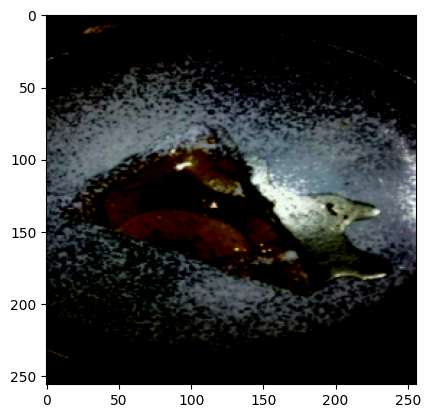

In [ ]:
import matplotlib.pyplot as plt
temp = next(iter(reduced_train_iter))
plt.imshow(temp[0].permute(1,2,0))
print(temp[1])

### Transform Dataset

Transform the dataset into a format that is compatible with the dataloader function of PyTorch. The PyTorch documentation can be accessed on https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [ ]:
# Creating train and test dataloader
train_dataloader = DataLoader(reduced_train_iter, shuffle=True, batch_size=32)
test_dataloader = DataLoader(reduced_test_iter, batch_size=32)

## Create the model for Image Classification

This section contains the code to either create a model from Scratch or using built-in PyTorch API modules. The basic architecture of the model is x -> (conv2d -> batchnorm2d -> maxpool2d -> activation)* -> flatten -> Linear*

In [ ]:
# A class that performs Conv2d, BatchNorm2d, activation, MaxPool2d
class ConvMaxPool(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool_size=2, activation=None):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding='same'
        )
        self.pool = nn.MaxPool2d(kernel_size=pool_size)
        self.activation = activation
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.pool(x)
        if self.activation:
            x = self.activation(x)

        return x

In [ ]:
import torch.nn.functional as F

# The model that will perform the classification
class MyImprovedImageIdentifier(LightningModule):
    def __init__(self):
        super().__init__()

        # creating a layer of ConvMaxPool
        self.layer = nn.Sequential(
            ConvMaxPool(3,9,3,2, nn.ReLU()), # (batch, 9, 128, 128)
            ConvMaxPool(9,27,3,2, nn.ReLU()), # (batch, 27, 64, 64)
            ConvMaxPool(27,81,3,2, nn.ReLU()), # (batch, 81, 32, 32)
            ConvMaxPool(81,27,3,2, nn.ReLU()), # (batch, 27, 16, 16)
            ConvMaxPool(27,9,3,2, nn.ReLU()), # (batch, 9, 8, 8)
            ConvMaxPool(9,90,3,2, nn.ReLU()), # (batch, 90, 4, 4)
        )

        # multiple layers of Linear layers
        self.fc1 = nn.Linear(90*4*4, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 4096)
        self.fc4 = nn.Linear(4096, 16384)
        self.fc5 = nn.Linear(16384, 100)
        self.fc6 = nn.Linear(100, num_classes)
        self.dropout = nn.Dropout(0.5)  # a function that randomly zeros values in the tensor
        self.flatten = nn.Flatten()   # flatten the tensor
        self.accuracy = MulticlassAccuracy(num_classes=num_classes, k=1)  # built in accuracy function that takes number of classes and how many values to look for accuracy
        self.optimizer = optim.AdamW(self.parameters())  #using AdamW optimizer to optimize the params
        self.lr_scheduler = optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=3, gamma=0.1)

        # series of residual layers of varying hidden dimension
        self.residual1 = nn.Sequential(
            nn.Linear(num_classes, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        self.residual2 = nn.Sequential(
            nn.Linear(num_classes, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        self.residual3 = nn.Sequential(
            nn.Linear(num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        self.residual4 = nn.Sequential(
            nn.Linear(num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        self.residual5 = nn.Sequential(
            nn.Linear(num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.residual6 = nn.Sequential(
            nn.Linear(num_classes, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.layer(x)   # passing input through ConvMaxPool layers
        x = x.reshape(x.size(0), -1)    # reshaping the input into shape (32, -1)
        x = F.relu(self.fc1(x))   # first linear layer -> ReLU
        x = self.dropout(x)   # dropout
        x = F.relu(self.fc2(x))   # 2nd linear layer -> ReLU
        x = self.dropout(x)   # dropout
        x = F.relu(self.fc3(x))   # 3rd linear layer -> ReLU
        x = self.dropout(x)   # dropout
        x = F.relu(self.fc4(x))   # 4th linear layer -> ReLU
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)     # (100 -> 3)
        x = self.residual1(x) + x #residual layers
        x = self.residual2(x) + x
        x = self.residual3(x) + x
        x = self.residual4(x) + x
        x = self.residual5(x) + x
        x = self.residual6(x) + x
        return x

    def loss(self, y, target):
        return F.cross_entropy(y, target)

    def training_step(self, batch, batch_index):
        x, target = batch   # get inputs and labels
        output = self.forward(x)  # calculate outputs using model
        loss = self.loss(output, target)  # calculate loss
        acc = self.accuracy.update(output, target)  #calculate accuracy
        self.log('loss', loss, prog_bar=True)   # log loss
        self.log('train_acc', acc.compute(), prog_bar=True)   # log accuracy
        return loss

    def configure_optimizers(self):
        return self.optimizer

    def validation_step(self, batch, batch_index):
        inputs, targets = batch   # get inputs and labels
        outputs = self.forward(inputs)    # calculate outputs using model
        acc = self.accuracy.update(outputs, targets)    # calculate accuracy
        self.log('val_acc', acc.compute(), prog_bar=True)   # log accurcay


In [ ]:
# creating a summary of model using a batch of data
(xs, ys) = next(iter(train_dataloader))
model = MyImprovedImageIdentifier()
summary(model, xs)
# y = model(xs)
# y[0], ys[0]

                                    Kernel Shape        Output Shape  \
Layer                                                                  
0_layer.0.Conv2d_conv               [3, 9, 3, 3]   [32, 9, 256, 256]   
1_layer.0.BatchNorm2d_batchnorm              [9]   [32, 9, 256, 256]   
2_layer.0.MaxPool2d_pool                       -   [32, 9, 128, 128]   
3_layer.0.ReLU_activation                      -   [32, 9, 128, 128]   
4_layer.1.Conv2d_conv              [9, 27, 3, 3]  [32, 27, 128, 128]   
5_layer.1.BatchNorm2d_batchnorm             [27]  [32, 27, 128, 128]   
6_layer.1.MaxPool2d_pool                       -    [32, 27, 64, 64]   
7_layer.1.ReLU_activation                      -    [32, 27, 64, 64]   
8_layer.2.Conv2d_conv             [27, 81, 3, 3]    [32, 81, 64, 64]   
9_layer.2.BatchNorm2d_batchnorm             [81]    [32, 81, 64, 64]   
10_layer.2.MaxPool2d_pool                      -    [32, 81, 32, 32]   
11_layer.2.ReLU_activation                     -    [32, 81, 32,

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_layer.0.Conv2d_conv,"[3, 9, 3, 3]","[32, 9, 256, 256]",252.0,15925248.0
1_layer.0.BatchNorm2d_batchnorm,[9],"[32, 9, 256, 256]",18.0,9.0
2_layer.0.MaxPool2d_pool,-,"[32, 9, 128, 128]",NaN,NaN
3_layer.0.ReLU_activation,-,"[32, 9, 128, 128]",NaN,NaN
4_layer.1.Conv2d_conv,"[9, 27, 3, 3]","[32, 27, 128, 128]",2214.0,35831808.0
5_layer.1.BatchNorm2d_batchnorm,[27],"[32, 27, 128, 128]",54.0,27.0
6_layer.1.MaxPool2d_pool,-,"[32, 27, 64, 64]",NaN,NaN
7_layer.1.ReLU_activation,-,"[32, 27, 64, 64]",NaN,NaN
8_layer.2.Conv2d_conv,"[27, 81, 3, 3]","[32, 81, 64, 64]",19764.0,80621568.0



## Training

This section contains the training and logging of the module and the metrics for each step.

In [ ]:
# creating a logger and trainer
logger = CSVLogger('lightning_logs', name='my_ic_module')
trainer = Trainer(logger=logger ,max_epochs=15)

# training the model
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name      | Type       | Params
------------------------------------------
0  | layer     | Sequential | 52.0 K
1  | fc1       | Linear     | 368 K 
2  | fc2       | Linear     | 263 K 
3  | fc3       | Linear     | 4.2 M 
4  | fc4       | Linear     | 67.1 M
5  | fc5       | Linear     | 1.6 M 
6  | fc6       | Linear     | 303   
7  | dropout   | Dropout    | 0     
8  | flatten   | Flatten    | 0     
9  | residual1 | Sequential | 703   
10 | residual2 | Sequential | 7.2 K 
11 | residual3 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


<Axes: xlabel='epoch'>

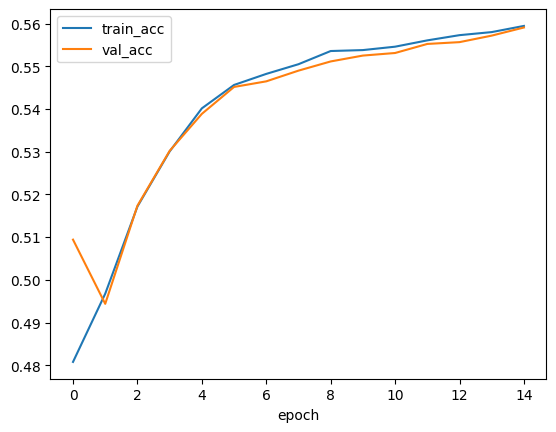

In [ ]:
import pandas as pd
df = pd.read_csv('lightning_logs/my_ic_module/version_0/metrics.csv')
df.drop(labels=['loss', 'step'], inplace=True, axis=1)
df.groupby('epoch').mean().plot.line()

In [ ]:
xs[0], ys[0]

(tensor([[[ 0.9137,  0.9216,  0.9373,  ..., -0.8275, -0.8275, -0.8353],
          [ 0.9137,  0.9294,  0.9451,  ..., -0.8275, -0.8275, -0.8275],
          [ 0.9137,  0.9294,  0.9373,  ..., -0.8353, -0.8353, -0.8431],
          ...,
          [-0.1294, -0.1137, -0.1137,  ..., -0.5922, -0.6314, -0.6784],
          [-0.1373, -0.1294, -0.1373,  ..., -0.6157, -0.6549, -0.7098],
          [-0.1294, -0.1451, -0.1529,  ..., -0.6627, -0.7020, -0.7647]],
 
         [[ 0.9373,  0.9451,  0.9608,  ..., -0.8667, -0.8667, -0.8745],
          [ 0.9373,  0.9529,  0.9686,  ..., -0.8667, -0.8667, -0.8667],
          [ 0.9373,  0.9529,  0.9608,  ..., -0.8667, -0.8667, -0.8745],
          ...,
          [-0.1686, -0.1529, -0.1451,  ..., -0.5922, -0.6314, -0.6706],
          [-0.1843, -0.1686, -0.1765,  ..., -0.6314, -0.6706, -0.7333],
          [-0.2000, -0.1922, -0.1922,  ..., -0.6863, -0.7333, -0.8039]],
 
         [[ 0.9765,  0.9843,  0.9922,  ..., -0.8902, -0.8902, -0.8980],
          [ 0.9765,  0.9843,

# Deployment

Save the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# saving the model
torch.save(model, '/content/drive/MyDrive/MLModel/model.pth')
